In [1]:
from   IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [3]:
def updatePLT(W, l=4, w=3, fontsize=10):
    plt.rcParams.update({
        'figure.figsize': (W, W/(l/w)),     # 4:3 aspect ratio
        'font.size' : fontsize,                   # Set font size to 11pt
        'axes.labelsize': fontsize,               # -> axis labels
        'legend.fontsize': fontsize,              # -> legends
        'font.family': 'lmodern',
        'text.usetex': True,
        'text.latex.preamble': (            # LaTeX preamble
            r'\usepackage{lmodern}'
            # ... more packages if needed
        )
    })

# Solving the Lotka Volterra ODE

In [ ]:
def solveLotkaVolterra(_phi, _beta, _c, _T, _k, _nb_t=10000):
    _ts         = np.linspace(0, _T, _nb_t)
    _a          = np.array([_phi, -_beta, -_beta*_beta*_c])
    
    _b          = np.array([0, -_beta, _beta])
    
    _A          = np.array([[-1, _c, 1/_beta],
                           [-1, _c, 1/_beta],
                           [-1, _c, 1/_beta]])/2/_k
    
    _Gt         = lambda t, s: -_a + -np.diag(s) @ (_b + _A@s)    
    
    _sol        = solve_ivp(_Gt, 
                           [_T, 0], 
                           np.array([-_c, 0, 0]), 
                           t_eval = _ts[::-1])
    _Gt         = _sol.y
    
    return _Gt, _ts

In [ ]:
def solveLotkaVolterra(_phi, _beta, _c, _T, _k, _nb_t=200000):
    _ts         = np.linspace(0, _T, _nb_t)
    _a          = np.array([_phi, -_beta, -_beta*_beta*_c])
    
    _b          = np.array([0, -_beta, _beta])
    
    _A          = np.array([[-1, _c, 1/_beta],
                           [-1, _c, 1/_beta],
                           [-1, _c, 1/_beta]])/2/_k
    
    _Gt         = lambda t, s: -_a + -np.diag(s) @ (_b + _A@s)    
    
    _sol        = solve_ivp(_Gt, 
                           [_T, 0], 
                           np.array([0, 0, _beta * _c]), 
                           t_eval = _ts[::-1])
    _Gt         = _sol.y
    
    return _Gt, _ts

In [ ]:
def solveLotkaVolterra2(_phi, _beta, _c, _T, _k, _nb_t=20000):
    _ts         = np.linspace(0, _T, _nb_t)
    
    _Gt         = lambda t, s: -np.array([-_beta*_c - _phi + s[2]        + s[0] * (s[0] + _c*s[1]) / 2 / _k ,
                                          -_beta - _beta * s[1]          + s[1] * (s[0] + _c*s[1]) / 2 / _k ,
                                          -_beta*_beta*_c + _beta * s[2] + s[2] * (s[0] + _c*s[1]) / 2 / _k])

    sol        = solve_ivp(_Gt, 
                           [_T, 0], 
                           np.array([_c, 0, _beta * _c]), 
                           t_eval = _ts[::-1])
    Gt         = sol.y
    
    return Gt, _ts

In [ ]:
_phi  = 0.5
_beta = 50
_c    = 1e-3
_T    = 1
_k    = 1

Gt, ts = solveLotkaVolterra(_phi, _beta, _c, _T, _k)

g3 = Gt[1, ::-1]; g4 = Gt[2, ::-1]; g2 = g4 / _beta  - Gt[0, ::-1]

updatePLT(W=6, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes[0].plot(ts, g2,  color='k', lw=2.5, ls='-.'); axes[0].set_xlabel(r'$t$')
axes[1].plot(ts, g3,  color='k', lw=2.5, ls='-.'); axes[1].set_xlabel(r'$t$')
axes[2].plot(ts, g4,  color='k', lw=2.5, ls='-.'); axes[2].set_xlabel(r'$t$')
axes[0].set_title(r'$g_{2, t}$'); axes[1].set_title(r'$g_{3, t}$'); axes[2].set_title(r'$g_{4, t}$')

In [ ]:
Gt, ts = solveLotkaVolterra2(_phi, _beta,  _c , _T    , _k  )

g2 = Gt[0, ::-1]; g3 = Gt[1, ::-1]; g4 = Gt[2, ::-1]

updatePLT(W=6, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes[0].plot(ts, g2,  color='k', lw=2.5, ls='-.'); axes[0].set_xlabel(r'$t$')
axes[1].plot(ts, g3,  color='k', lw=2.5, ls='-.'); axes[1].set_xlabel(r'$t$')
axes[2].plot(ts, g4,  color='k', lw=2.5, ls='-.'); axes[2].set_xlabel(r'$t$')
axes[0].set_title(r'$g_{2, t}$'); axes[1].set_title(r'$g_{3, t}$'); axes[2].set_title(r'$g_{4, t}$')

# Strategy simulations

In [196]:
###############
# Parameters 
##############

# performance criterion
phi  = 5 #.01
beta = 5
c    = 1e-2 # transient impact
k    = 1e-3 # trading friction

# Time steps
T    = 1
nb_t = 1001
dt   = T / (nb_t - 1)

# Signal (OU)
r_signal     = 0.1
sigma_signal = 5

# Fundamental price
sigma_price   = 0.5
F0            = 100 

# transient impact
sigma_transient = 0.

# Inventory to liquidate
Q0       = 100

Text(0.5, 1.0, '$g_{4, t}$')

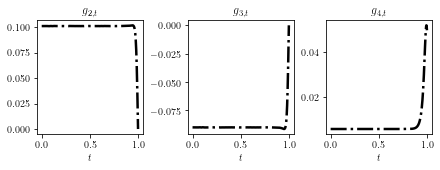

In [197]:
# solve the ODE system
Gt, ts = solveLotkaVolterra(_phi  = phi, _beta = beta, _c = c, _T = T, _nb_t = nb_t, _k = k)
g3 = Gt[1, ::-1]; g4 = Gt[2, ::-1]; g2 = g4 / beta  - Gt[0, ::-1]

#Gt, ts = solveLotkaVolterra2(_phi  = phi, _beta = beta, _c = c, _T = T, _nb_t = nb_t, _k = k)
#g3 = Gt[1, ::-1]; g4 = Gt[2, ::-1]; g2 = Gt[0, ::-1]

updatePLT(W=6, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes[0].plot(ts, g2,  color='k', lw=2.5, ls='-.'); axes[0].set_xlabel(r'$t$')
axes[1].plot(ts, g3,  color='k', lw=2.5, ls='-.'); axes[1].set_xlabel(r'$t$')
axes[2].plot(ts, g4,  color='k', lw=2.5, ls='-.'); axes[2].set_xlabel(r'$t$')
axes[0].set_title(r'$g_{2, t}$'); axes[1].set_title(r'$g_{3, t}$'); axes[2].set_title(r'$g_{4, t}$')

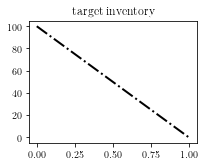

In [198]:
##############################
# Target strategy: TWAP 
############################
q_target = np.linspace(Q0, 0, nb_t)

updatePLT(3, l=4, w=3, fontsize=10)
plt.plot(ts, q_target, color='k', lw=2, ls='-.')
_ = plt.title('target inventory')
plt.show()

### Simulate fundamental prices & signals

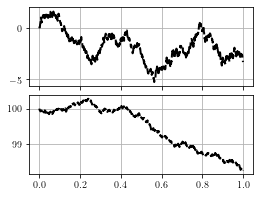

In [199]:
# random parameters
np.random.seed(13)

W  = np.random.randn(nb_t, 1)
M1 = np.random.randn(nb_t, 1) * sigma_price * np.sqrt(dt)

# Simulate a signal:  OU process
alpha        = np.empty((nb_t, 1))
alpha[0]     = 0
for i in range(1, nb_t):
    alpha[i] = alpha[i-1]  - r_signal * alpha[i-1] * dt + sigma_signal * W[i] * np.sqrt(dt)

# Simulate the fundamental price
F        = np.empty((nb_t, 1))
F[0]     = F0
for i in range(1, nb_t):
    F[i] = F[i-1]  + alpha[i-1] * dt + M1[i]

updatePLT(3.5, l=4, w=3, fontsize=10)
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True)
ax1.plot(ts, alpha, color='k', lw=2, ls='--')
ax2.plot(ts, F,     color='k', lw=2, ls='--')
ax1.grid(); ax2.grid()

### Get optimal tracking speed

In [200]:
# Compute g1 with closed-form 
expterm1 = np.array([sum( (np.exp(np.sum(g2[it:iss] * dt + c*g3[it:iss]*dt)/2/k) * dt for iss in range(it, nb_t-1)) ) for it in range(nb_t)])
expterm2 = np.array([sum( (q_target[iss] * np.exp(np.sum(g2[it:iss] * dt + c*g3[it:iss]*dt)/2/k) * dt  for iss in range(it, nb_t-1)) ) for it in range(nb_t) ])
g1       = phi * expterm2 + sigma_signal * alpha[:,0] * expterm1

Text(0.5, 0, '$t$')

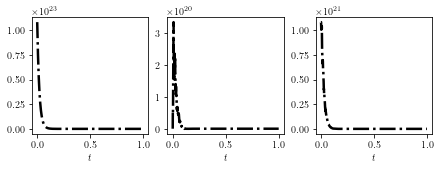

In [201]:
# solve the ODE system
updatePLT(W=6, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes[0].plot(ts, phi * Q0 * expterm2,  color='k', lw=2.5, ls='-.'); axes[0].set_xlabel(r'$t$')
axes[1].plot(ts, sigma_signal * alpha[:,0] * expterm1,  color='k', lw=2.5, ls='-.'); axes[1].set_xlabel(r'$t$')
axes[2].plot(ts, g1,  color='k', lw=2.5, ls='-.'); axes[2].set_xlabel(r'$t$')

In [202]:
# compute g1 with mc
if False:
    g1_mc = np.zeros(nb_t)
    for n in range(5):
        if (n%10==0): print(n) 
        W  = np.random.randn(nb_t, 1)
        mc_alpha        = np.empty((nb_t, 1))
        mc_alpha[0]     = 0
        for i in range(1, nb_t):
            mc_alpha[i] = mc_alpha[i-1]  - r_signal * mc_alpha[i-1] * dt + sigma_signal * W[i] * np.sqrt(dt)

        it = 0
        g1_mc += np.array([sum(((mc_alpha[iss,0] + phi * q_target[iss]) * np.exp(np.sum(g2[it:iss] * dt + c*g3[it:iss]*dt)/2/k) * dt 
                                for iss in range(it, nb_t-1))) 
                           for it in range(nb_t)])

    g1_mc/=5
    
    updatePLT(3, l=4, w=3, fontsize=10)
    plt.plot(ts, g1_mc, color='k', lw=2, ls='-.')
    plt.plot(ts, g1, color='b', lw=2, ls='--')
    _ = plt.title('g1')
    plt.show()
#np.shape(mc_alpha[:,0] + phi * q_target )

Text(0.5, 1.0, '$S=I+F$')

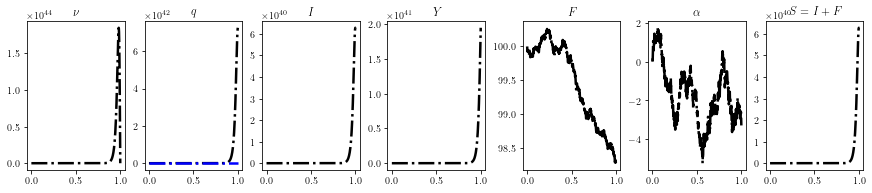

In [203]:
Q        = np.empty((nb_t, 1))
I        = np.empty((nb_t, 1))
Y        = np.empty((nb_t, 1))
nu       = np.empty((nb_t, 1))

Q[0]     = Q0
I[0]     = 0
Y[0]     = 0
nu[0]    = 0

sigma_transient = 0.

np.random.seed(13)
M2 = np.random.randn(nb_t, 1) * sigma_transient * np.sqrt(dt)

# FBSDE system
for i in range(0, nb_t-1):
    nu[i]   = (g1[i] + g2[i] * Q[i] + g3[i] * I[i] + g4[i] * Y[i]) / 2 / k
    Q[i+1]  = Q[i] + nu[i] * dt    
    Y[i+1]  = Y[i] + (Q[i] - beta * Y[i]) * dt
    I[i+1]  = I[i] + c * nu[i] * dt - beta * I[i] * dt + M2[i]

# plot the solution
updatePLT(W=12, l=14, w=3, fontsize=10)
fig, axes = plt.subplots(1, 7, constrained_layout=True)
axes[0].plot(ts, nu,        color='k', lw=2.5, ls='-.');  axes[0].set_title(r'$\nu$')
axes[1].plot(ts, Q,         color='k', lw=2.5, ls='-.');  axes[1].set_title(r'$Q$')
axes[1].plot(ts, q_target,  color='b', lw=2.5, ls='-.');  axes[1].set_title(r'$q$')
axes[2].plot(ts, I,         color='k', lw=2.5, ls='-.');  axes[2].set_title(r'$I$')
axes[3].plot(ts, Y,         color='k', lw=2.5, ls='-.');  axes[3].set_title(r'$Y$')
axes[4].plot(ts, F,         color='k', lw=2.5, ls='-.');  axes[4].set_title(r'$F$')
axes[5].plot(ts, alpha,     color='k', lw=2.5, ls='-.');  axes[5].set_title(r'$\alpha$')
axes[6].plot(ts, I+F,       color='k', lw=2.5, ls='-.');  axes[6].set_title(r'$S=I+F$') 

Text(0.5, 1.0, '$g4 * Y / 2k$')

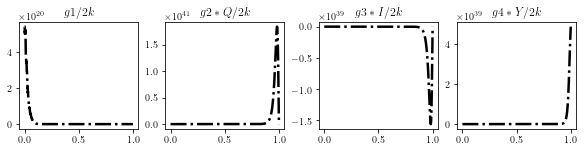

In [204]:
updatePLT(W=8, l=12, w=3, fontsize=10)
fig, axes = plt.subplots(1, 4, constrained_layout=True)
axes[0].plot(ts, dt*g1/2/k,  color='k', lw=2.5, ls='-.'); axes[0].set_title(r'$g1 / 2k$')
axes[1].plot(ts, dt*g2*Q[:,0]/2/k,  color='k', lw=2.5, ls='-.'); axes[1].set_title(r'$g2 * Q / 2k$')
axes[2].plot(ts, dt*g3*I[:,0]/2/k,  color='k', lw=2.5, ls='-.'); axes[2].set_title(r'$g3 * I / 2k$')
axes[3].plot(ts, dt*g4*Y[:,0]/2/k,  color='k', lw=2.5, ls='-.'); axes[3].set_title(r'$g4 * Y / 2k$')
#axes[4].plot(ts, alpha,  color='k', lw=2.5, ls='-.'); axes[4].set_title(r'$\alpha$')

Text(0.5, 0, '$t$')

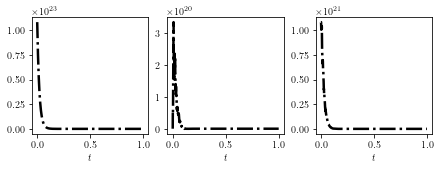

In [205]:
# solve the ODE system
updatePLT(W=6, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes[0].plot(ts, phi * Q0 * expterm2,  color='k', lw=2.5, ls='-.'); axes[0].set_xlabel(r'$t$')
axes[1].plot(ts, sigma_signal * alpha[:,0] * expterm1,  color='k', lw=2.5, ls='-.'); axes[1].set_xlabel(r'$t$')
axes[2].plot(ts, g1,  color='k', lw=2.5, ls='-.'); axes[2].set_xlabel(r'$t$')

# Multiple simulations

In [207]:
def solveLotkaVolterra(_phi, _beta, _c, _T, _k, _nb_t=20000):
    _ts         = np.linspace(0, _T, _nb_t)
    
    _Gt         = lambda t, s: -np.array([-_beta*_c - _phi + s[2]        + s[0] * (s[0] + _c*s[1]) / 2 / _k ,
                                          -_beta - _beta * s[1]          + s[1] * (s[0] + _c*s[1]) / 2 / _k ,
                                          _beta*_beta*_c + _beta * s[2] + s[2] * (s[0] + _c*s[1]) / 2 / _k])

    sol        = solve_ivp(_Gt, 
                           [_T, 0], 
                           np.array([_c, 0, _c * _beta]), 
                           t_eval = _ts[::-1])
    Gt         = sol.y
    #_beta * _c
    return Gt, _ts

def get_simulation(_dt, _nb_t, _r_signal, _c, _k, _phi, _sigma_signal, 
                   _beta, _sigma_transient, _sigma_price, _q_target, 
                   _F0, _Q0, _T):
    
    # Solve the Lotka Volterra system
    Gt, ts = solveLotkaVolterra(_phi  = _phi, _beta = _beta, _c = _c, _T = _T, _nb_t = _nb_t, _k = _k)
    #_g3 = Gt[1, ::-1]; _g4 = Gt[2, ::-1]; _g2 = _g4 / _beta  - Gt[0, ::-1]
    _g3 = Gt[1, ::-1]; _g4 = Gt[2, ::-1]; _g2 = Gt[0, ::-1]
    
    W  = np.random.randn(_nb_t, 1)
    M1 = np.random.randn(_nb_t, 1) * _sigma_price * np.sqrt(_dt)
    
    # Simulate a signal:  OU process
    alpha        = np.empty((_nb_t, 1))
    alpha[0]     = 0
    for i in range(1, nb_t):
        alpha[i] = alpha[i-1]  - _r_signal * alpha[i-1] * _dt + _sigma_signal * W[i] * np.sqrt(_dt)
    
    # Simulate the fundamental price
    F        = np.empty((_nb_t, 1))
    F[0]     = _F0
    for i in range(1, _nb_t):
        F[i] = F[i-1]  + alpha[i-1] * _dt + M1[i]
        
    # Compute g1 with closed-form 
    expterm1 = np.array([sum( (np.exp(np.sum(_g2[it:iss] * _dt + _c*_g3[it:iss]*dt)/2/_k) * _dt for iss in range(it, _nb_t-1)) ) for it in range(_nb_t)])
    expterm2 = np.array([sum( (_q_target[iss] * np.exp(np.sum(_g2[it:iss] * _dt + _c * _g3[it:iss]*_dt)/2/_k) * _dt  for iss in range(it, _nb_t-1)) ) for it in range(_nb_t) ])
    g1       = _phi * expterm2 + _sigma_signal * alpha[:,0] * expterm1
    
    # Simulate trading
    Q        = np.empty((_nb_t, 1))
    I        = np.empty((_nb_t, 1))
    Y        = np.empty((_nb_t, 1))
    nu       = np.empty((_nb_t, 1))

    Q[0]     = _Q0
    I[0]     = 0
    Y[0]     = 0
    nu[0]    = 0

    M2 = np.random.randn(_nb_t, 1) * _sigma_transient * np.sqrt(_dt)

    # FBSDE system
    for i in range(0, _nb_t-1):
        nu[i]   = (g1[i] + _g2[i] * Q[i] + _g3[i] * I[i] + _g4[i] * Y[i]) / 2 / _k
        Q[i+1]  = Q[i] + nu[i] * _dt    
        Y[i+1]  = Y[i] + (Q[i] - _beta * Y[i]) * _dt
        I[i+1]  = I[i] + _c * nu[i] * _dt - _beta * I[i] * _dt + M2[i]

    return ts, nu, Q, Y, I,  alpha, F, g1, _g2, _g3, _g4

In [208]:
###############
# Parameters 
##############
# Time steps
T    = 1
nb_t = 1001
dt   = T / (nb_t - 1)

# Inventory to liquidate
Q0       = 100
q_target = np.linspace(Q0, 0, nb_t)

In [219]:
np.random.seed(10)
ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4 = get_simulation(_dt=dt, _nb_t=nb_t, 
                                                           _r_signal=5, _c=0., _k=1e-3, _phi=0.5, _sigma_signal=0, 
                                                           _beta=1, _sigma_transient=0., _sigma_price = 1,
                                                           _q_target=q_target, _F0=Q0, _Q0=Q0, _T=T)

Text(0.5, 1.0, '$S=I+F$')

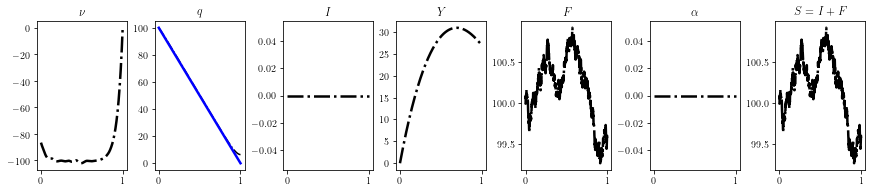

In [220]:
updatePLT(W=12, l=14, w=3, fontsize=10)
fig, axes = plt.subplots(1, 7, constrained_layout=True)
axes[0].plot(ts, nu,        color='k', lw=2.5, ls='-.');  axes[0].set_title(r'$\nu$')
axes[1].plot(ts, Q,         color='k', lw=1.5, ls='-.');  axes[1].set_title(r'$Q$')
axes[1].plot(ts, q_target,  color='b', lw=2.5, ls='-');   axes[1].set_title(r'$q$')
axes[2].plot(ts, I,         color='k', lw=2.5, ls='-.');  axes[2].set_title(r'$I$')
axes[3].plot(ts, Y,         color='k', lw=2.5, ls='-.');  axes[3].set_title(r'$Y$')
axes[4].plot(ts, F,         color='k', lw=2.5, ls='-.');  axes[4].set_title(r'$F$')
axes[5].plot(ts, alpha,     color='k', lw=2.5, ls='-.');  axes[5].set_title(r'$\alpha$')
axes[6].plot(ts, I+F,       color='k', lw=2.5, ls='-.');  axes[6].set_title(r'$S=I+F$') 

Text(0.5, 1.0, '$g4 * Y / 2k$')

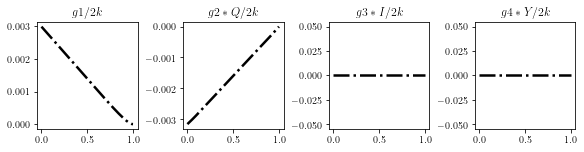

In [221]:
updatePLT(W=8, l=12, w=3, fontsize=10)
fig, axes = plt.subplots(1, 4, constrained_layout=True)
axes[0].plot(ts, dt*g1,  color='k', lw=2.5, ls='-.'); axes[0].set_title(r'$g1 / 2k$')
axes[1].plot(ts, dt*g2*Q[:,0],  color='k', lw=2.5, ls='-.'); axes[1].set_title(r'$g2 * Q / 2k$')
axes[2].plot(ts, dt*g3*I[:,0],  color='k', lw=2.5, ls='-.'); axes[2].set_title(r'$g3 * I / 2k$')
axes[3].plot(ts, dt*g4*Y[:,0],  color='k', lw=2.5, ls='-.'); axes[3].set_title(r'$g4 * Y / 2k$')
#axes[4].plot(ts, alpha,  color='k', lw=2.5, ls='-.'); axes[4].set_title(r'$\alpha$')

Text(0.5, 1.0, '$g4$')

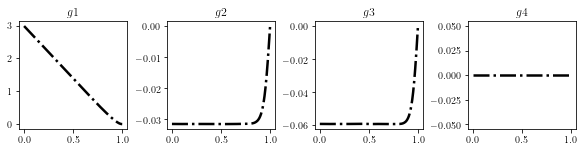

In [222]:
updatePLT(W=8, l=12, w=3, fontsize=10)
fig, axes = plt.subplots(1, 4, constrained_layout=True)
axes[0].plot(ts, g1,  color='k', lw=2.5, ls='-.'); axes[0].set_title(r'$g1$')
axes[1].plot(ts, g2,  color='k', lw=2.5, ls='-.'); axes[1].set_title(r'$g2$')
axes[2].plot(ts, g3,  color='k', lw=2.5, ls='-.'); axes[2].set_title(r'$g3$')
axes[3].plot(ts, g4,  color='k', lw=2.5, ls='-.'); axes[3].set_title(r'$g4$')
#axes[4].plot(ts, alpha,  color='k', lw=2.5, ls='-.'); axes[4].set_title(r'$\alpha$')

## Effect of tracking penalty

In [180]:
Trajectories = {}
for n in range(20):
    if (n%5)==0: print(n)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt       = dt, 
                                                               _nb_t      = nb_t, 
                                                               _r_signal  =  1,     _sigma_signal  =  5, 
                                                               _c         =  1e-3,  _k             =  1e-3,  _beta  =  5, 
                                                               _phi       =  0.5,
                                                               _sigma_price = 1, _T = 1,
                                                               _sigma_transient = 0., 
                                                               _q_target  =  q_target, _F0=100, _Q0=100)
    Trajectories[n] = (Q, alpha)

0
5
10
15


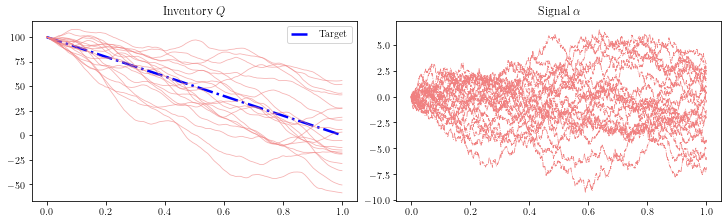

In [181]:
updatePLT(W=10, l=10, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
for n in Trajectories.keys():
    axes[0].plot(ts, Trajectories[n][0],  color='lightcoral', lw=0.8, ls='-', alpha=0.6)
    axes[1].plot(ts, Trajectories[n][1],  color='lightcoral', lw=0.8, ls='-.')

axes[0].legend(['Target'])
axes[1].set_title(r'Signal $\alpha$')    
axes[0].set_title(r'Inventory $Q$')   

plt.savefig('results/penalty_loose.pdf')

In [182]:
Trajectories = {}

for n in range(20):
    if (n%5)==0: print(n)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt        = dt, 
                                                               _nb_t      = nb_t, 
                                                               _r_signal  =  1,     _sigma_signal  =  5, 
                                                               _c         =  1e-3,  _k             =  1e-3,  _beta  =  5, 
                                                               _phi       =  2,
                                                               _sigma_price = 1, _T = 1, 
                                                               _sigma_transient = 0.5, 
                                                               _q_target  =  q_target, _F0=100, _Q0=100)
    Trajectories[n] = (Q, alpha)

0
5
10
15


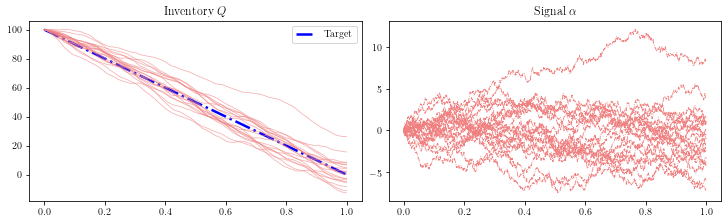

In [183]:
updatePLT(W=10, l=10, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
for n in Trajectories.keys():
    axes[0].plot(ts, Trajectories[n][0],  color='lightcoral', lw=0.8, ls='-', alpha=0.6)
    axes[1].plot(ts, Trajectories[n][1],  color='lightcoral', lw=0.8, ls='-.')

axes[0].legend(['Target'])
axes[1].set_title(r'Signal $\alpha$')    
axes[0].set_title(r'Inventory $Q$')   

plt.savefig('results/penalty_tight.pdf')

In [184]:
Trajectories = {}
for phi_ in (1e-1, 3e-1, 5e-1, 1):
    np.random.seed(10)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt        = dt, 
                                                               _nb_t      = nb_t, 
                                                               _r_signal  =  1,     _sigma_signal  =  5, 
                                                               _c         =  1e-3,  _k             =  1e-3,  _beta  =  5, 
                                                               _phi       =  phi_,
                                                               _sigma_price = 1, _T = 1, 
                                                               _sigma_transient = 0., 
                                                               _q_target  =  q_target, _F0=100, _Q0=100)
    Trajectories[phi_] = Q

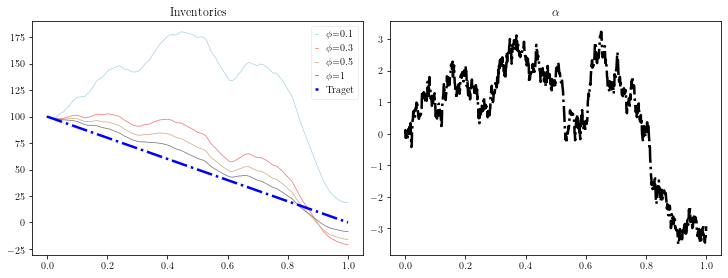

In [185]:
updatePLT(W=10, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

for (phi_, clr) in zip(Trajectories.keys(), ('lightblue', 'lightcoral', 'tan', 'grey')):
    axes[0].plot(ts, Trajectories[phi_],  color=clr, lw=0.8, ls='-', alpha=1)
axes[0].set_title(r'Inventories')
axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
axes[0].legend( [f'$\phi$={phi_}' for phi_ in Trajectories.keys()] + ['Traget'], handlelength=0.3, framealpha=0.3 )
axes[1].plot(ts, alpha,     color='k', lw=2.5, ls='-.');  axes[1].set_title(r'$\alpha$') 
plt.savefig('results/penalty_different_values.pdf')

### Effect of signal strength

In [186]:
Trajectories = {}
for sigma_signal_ in (1, 2, 5, 10):
    np.random.seed(10)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt        = dt, 
                                                           _nb_t      = nb_t, 
                                                           _r_signal  =  10,     _sigma_signal  =  sigma_signal_, 
                                                           _c         =  1e-3,  _k  =  1e-3,  _beta  =  1, 
                                                           _phi       =  0.5,
                                                           _sigma_price = 1, _T = 1, 
                                                           _sigma_transient = 0., 
                                                           _q_target  =  q_target, _F0=Q0, _Q0=Q0)
    Trajectories[sigma_signal_] = (Q, alpha)

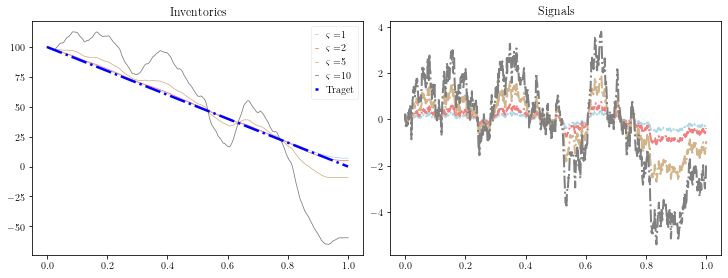

In [187]:
updatePLT(W=10, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

for (phi_, clr) in zip(Trajectories.keys(), ('lightblue', 'lightcoral', 'tan', 'grey')):
    axes[0].plot(ts, Trajectories[phi_][0],  color=clr, lw=0.8, ls='-', alpha=1)
    axes[1].plot(ts, Trajectories[phi_][1],  color=clr, lw=2., ls='-.');  axes[1].set_title(r'$\alpha$')

axes[0].set_title(r'Inventories')
axes[1].set_title(r'Signals')

axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
axes[0].legend( [r'$\varsigma= $' +f'{phi_}' for phi_ in Trajectories.keys()] + ['Traget'], handlelength=0.3, framealpha=0.3)
plt.savefig('results/signalstrength_different_values.pdf')

# Effect of transient impact

In [188]:
Trajectories = {}
for c_ in (0, 1e-3, 5e-3, 1e-2):
    np.random.seed(10)
    print('c=',c_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt        = dt, 
                                                               _nb_t      = nb_t, 
                                                               _r_signal  =  10,     _sigma_signal     =  5, 
                                                               _c         =  c_,  _k  =  1e-3,  _beta  =  5, 
                                                               _phi       =  0.5,
                                                               _sigma_price = 1, _T = 1,
                                                               _sigma_transient = 0., 
                                                               _q_target  =  q_target, _F0=Q0, _Q0=Q0)
    Trajectories[c_] = (Q, alpha)

c= 0
c= 0.001
c= 0.005
c= 0.01


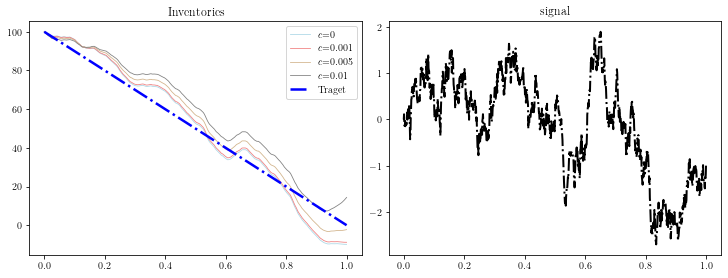

In [189]:
updatePLT(W=10, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

for (c_, clr) in zip(Trajectories.keys(), ('lightblue', 'lightcoral', 'tan', 'grey')):
    axes[0].plot(ts, Trajectories[c_][0],  color=clr, lw=0.8, ls='-', alpha=1)

axes[1].plot(ts, Trajectories[c_][1],  color='k', lw=2., ls='-.');  axes[1].set_title(r'$\alpha$')
axes[0].set_title(r'Inventories')
axes[1].set_title(r'signal')

axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
axes[0].legend( [f'$c$={c_}' for c_ in Trajectories.keys()] + ['Traget'])
axes[0].legend( [f'$c$={c_}' for c_ in Trajectories.keys()] + ['Traget'])
plt.savefig('results/transientimpact_different_values.pdf')

In [190]:
Trajectories = {}
for beta_ in (0.1, 1, 2, 5):
    np.random.seed(10)
    print('beta =',beta_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt        = dt, 
                                                               _nb_t      = nb_t, 
                                                               _r_signal  =  10,     _sigma_signal     =  5, 
                                                               _c         =  1e-3,  _k  =  5e-3,  _beta  =  beta_, 
                                                               _phi       =  0.1, 
                                                               _sigma_price = 1, _T = 1, 
                                                               _sigma_transient = 0., 
                                                               _q_target  =  q_target, _F0=Q0, _Q0=Q0)
    Trajectories[beta_] = (Q, alpha)

beta = 0.1
beta = 1
beta = 2
beta = 5


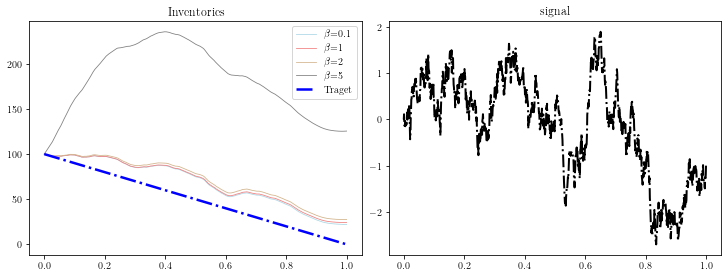

In [191]:
updatePLT(W=10, l=8, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

for (beta_, clr) in zip(Trajectories.keys(), ('lightblue', 'lightcoral', 'tan', 'grey')):
    axes[0].plot(ts, Trajectories[beta_][0],  color=clr, lw=0.8, ls='-', alpha=1)

axes[1].plot(ts, Trajectories[beta_][1],  color='k', lw=2., ls='-.');  axes[1].set_title(r'$\alpha$')
axes[0].set_title(r'Inventories')
axes[1].set_title(r'signal')

axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
axes[0].legend( [r'$\beta$' + f'={beta_}' for beta_ in Trajectories.keys()] + ['Traget'])
axes[0].legend( [r'$\beta$' + f'={beta_}' for beta_ in Trajectories.keys()] + ['Traget'])
plt.savefig('results/transientimpact_beta_different_values.pdf')

### Effect of transaction costs

In [192]:
Trajectories = {}
for k_ in (1e-4, 1e-3, 1e-2, 5e-2, 5e-1):
    np.random.seed(10)
    print('k =',k_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_simulation(_dt        = dt, 
                                                           _nb_t      = nb_t, 
                                                           _r_signal  =  10,    _sigma_signal     =  5, 
                                                           _c         =  1e-3,  _k  =  k_,  _beta  =  1, 
                                                           _phi       =  2,
                                                           _sigma_price = 1, _T = 1, 
                                                           _sigma_transient = 0., 
                                                           _q_target  =  q_target, _F0=Q0, _Q0=Q0)
    Trajectories[k_] = (Q, alpha)

k = 0.0001
k = 0.001
k = 0.01
k = 0.05
k = 0.5


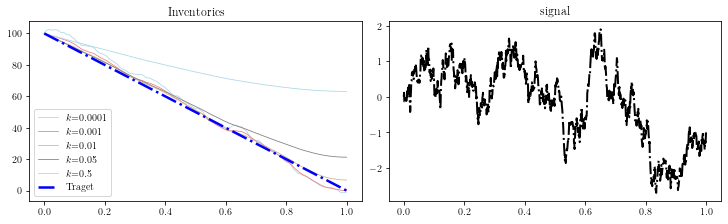

In [193]:
updatePLT(W=10, l=10, w=3, fontsize=10)
fig, axes = plt.subplots(1, 2, constrained_layout=True)

for (k_, clr) in zip(Trajectories.keys(), ('lightblue', 'lightcoral', 'tan', 'grey', 'lightblue')):
    axes[0].plot(ts, Trajectories[k_][0],  color=clr, lw=0.8, ls='-', alpha=1)

axes[1].plot(ts, Trajectories[k_][1],  color='k', lw=2., ls='-.');  axes[1].set_title(r'$\alpha$')
axes[0].set_title(r'Inventories')
axes[1].set_title(r'signal')

axes[0].plot(ts, q_target,  color='b', lw=2.5, ls='-.')
axes[0].legend( [f'$k$={k_}' for k_ in Trajectories.keys()] + ['Traget'])
axes[0].legend( [f'$k$={k_}' for k_ in Trajectories.keys()] + ['Traget'])

In [ ]:
# 